# Selecting the Most Efficient Method for a Biological Optimization Problem using Deep Bidirectional Encoder Representations from Transformers (BERT)
Designed to automatically select between deterministic and heuristic methods of solving a biological optimization problem, CutFree, using the BERT unsupervised model architecture.

## Import Dependencies

In [1]:
# system
import os
import csv

# data analysis
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# deep learning
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import DistilBertTokenizer, TFDistilBertModel, AdamWeightDecay
from numba import cuda

# check device
device = cuda.get_current_device()
device.reset()

## Create Directory Path to Save Model Information

In [2]:
# get previous model version
highest_model_number = 0
for directory in os.listdir('models'):
    model_number = int(directory.split("-V")[-1])
    if model_number >= highest_model_number:
        highest_model_number = model_number + 1

# create save directory
save_folder = 'models/AlgorithmClassifier-V' + str(highest_model_number)
save_folder

'models/AlgorithmClassifier-V7'

## Clean Dataset to Include Target

In [3]:
# read in data to dataframe
file_path = '../runtime-simulations/runtime_data.csv'
df_original = pd.read_csv(file_path)
df = df_original.copy()

# drop duplicate rows
duplicate_rows = df.duplicated(subset=['Oligo', 'Sites'], keep='first')
df = df[~duplicate_rows]

# fix the sites column
df['Sites'] = [s[5:-2] for s in df['Sites']]
df['Sites'] = [s.replace('"', '').replace(' ', '') for s in df['Sites']]
df['Sites'] = [s.split(',') for s in df['Sites']]

# add time discrepancy column
df['Discrepancy'] = df['CutFree_Time'] - df['CutFreeRL_Time']
df = df.sort_values(by=['Discrepancy'], ascending=True)
df = df.reset_index(drop=True)

# add correct algorithm column
conditions = [
    (df['CutFree_Time'] <= df['CutFreeRL_Time']),
    (df['CutFree_Time'] > df['CutFreeRL_Time'])
]
values = [0, 1] # 0 = CutFree, 1 = CutFreeRL
df['Algorithm'] = np.select(conditions, values)

# adjust correct algorithm based on degeneracy if it outside of the confidence interval 
# (i.e., ignore CutFreeRL if the degeneracy loss is too significant, typically caused by incomplete CutFreeRL output)
df.loc[df['CutFree_Degeneracy'] == 0, 'Algorithm'] = 1
df.loc[df['CutFreeRL_Degeneracy'] <= df['CutFree_Degeneracy'] - (df['CutFree_Degeneracy'] * 0.10), 'Algorithm'] = 0

# count classifcations
print(df['Algorithm'].value_counts())

df.shape, df.iloc[0]

Algorithm
0    20680
1     6654
Name: count, dtype: int64


((27334, 14),
 Unnamed: 0                                                          12114
 Oligo                             NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
 OligoLength                                                            39
 Sites                   [CGGWCCG, CCTNAGC, CACCTGC, GGTNACC, CASTGNN, ...
 TotalSites                                                             10
 SiteLength                                                              7
 CutFree_Randomer                  NNNNHWHDWNNNNWHDWDNNNDHWHDWNNNNWHDWNNNN
 CutFree_Degeneracy                                              45.068118
 CutFree_Time                                                      0.93772
 CutFreeRL_Randomer                WKHKHBHBHHNWHNWWWDWYVBBWNDANNRNWHDWNNNN
 CutFreeRL_Degeneracy                                            39.353041
 CutFreeRL_Time                                                   4.842045
 Discrepancy                                                     -3.904324
 Algorithm 

## Get Train, Validation, and Test Data

In [4]:
# gather text and label information
texts = []
labels = []
for index, row in df.iterrows():
    texts.append(row['Oligo'] + '; ' + ', '.join(row['Sites']))
    labels.append(row['Algorithm'])

In [5]:
# get random state to improve validity of results
random_state = np.random.randint(0, 1000)

# load train, validation, and test data for text
x_train, x_val, y_train, y_val = train_test_split(texts, labels, test_size=0.3, random_state=random_state)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=random_state)

print("Random State: ", random_state)
print("Train, Validation, and Test Sizes: ", len(x_train), len(x_val), len(x_test))

Random State:  665
Train, Validation, and Test Sizes:  19133 4100 4101


## Tokenize Input Sequences

In [6]:
# constants
MAX_SEQUENCE_LENGTH = 256
BATCH_SIZE = 24
BERT_MODEL_NAME = 'distilbert-base-uncased'

# initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL_NAME)

# tokenize training data
tokens_train = tokenizer.batch_encode_plus(x_train, max_length=MAX_SEQUENCE_LENGTH, padding='max_length', truncation=True, return_tensors='tf')

input_ids_train = tokens_train['input_ids']
attention_mask_train = tokens_train['attention_mask']

texts_train = (input_ids_train, attention_mask_train)
labels_train = tf.constant(y_train)

# tokenize validation data
tokens_val = tokenizer.batch_encode_plus(x_val, max_length=MAX_SEQUENCE_LENGTH, padding='max_length', truncation=True, return_tensors='tf')

input_ids_val = tokens_val['input_ids']
attention_mask_val = tokens_val['attention_mask']

texts_val = (input_ids_val, attention_mask_val)
labels_val = tf.constant(y_val)

## Compile, Train, and Save Model

In [7]:
# input layer
input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_ids', dtype='int32')
attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), name='attention_mask', dtype='int32')

# bert model
bert_model = TFDistilBertModel.from_pretrained(BERT_MODEL_NAME, output_attentions=False, output_hidden_states=False)([input_ids, attention_mask])
bert_output = bert_model.last_hidden_state[:, 0, :]

# mlp layers
mlp = tf.keras.Sequential([
    tf.keras.layers.Dropout(0.8, name='dropout_0'),
    tf.keras.layers.Dense(768, 
                          kernel_regularizer = tf.keras.regularizers.L1L2(1e-2),
                          bias_regularizer = tf.keras.regularizers.L1L2(1e-2),
                          activity_regularizer = tf.keras.regularizers.L1L2(1e-2),
                          name='dense_1'),
    tf.keras.layers.BatchNormalization(name='batch_norm_1'),
    tf.keras.layers.Dropout(0.4, name='dropout_1'),
    tf.keras.layers.Activation('relu', name='relu_1'),
    tf.keras.layers.Dense(128, 
                          kernel_regularizer = tf.keras.regularizers.L1L2(1e-2),
                          bias_regularizer = tf.keras.regularizers.L1L2(1e-2),
                          activity_regularizer = tf.keras.regularizers.L1L2(1e-2),
                          name='dense_2'),
    tf.keras.layers.BatchNormalization(name='batch_norm_2'),
    tf.keras.layers.Dropout(0.4, name='dropout_2'),
    tf.keras.layers.Activation('relu', name='relu_2'),
    tf.keras.layers.Dense(64, 
                          kernel_regularizer = tf.keras.regularizers.L1L2(1e-2),
                          bias_regularizer = tf.keras.regularizers.L1L2(1e-2),
                          activity_regularizer = tf.keras.regularizers.L1L2(1e-2),
                          name='dense_3'),
    tf.keras.layers.BatchNormalization(name='batch_norm_3'),
    tf.keras.layers.Dropout(0.4, name='dropout_3'),
    tf.keras.layers.Activation('relu', name='relu_3')
], name='mlp')(bert_output)

# output layer
output = tf.keras.layers.Dense(2, activation='softmax', name='output')(mlp)

# combine input and output layers to create model
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output, name='AlgorithmClassifier')

model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "AlgorithmClassifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 256, 768),                                                   
                                 hidden_states=None                             

In [8]:
# create optimizer and loss function
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# compile model
model.compile(optimizer, loss, metrics=['accuracy'])

# class weights (if not balanced)
class_weights = dict(enumerate(compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=np.array(y_train))))

# callbacks for early stopping, saving checkpoints, and visualizing in tensorboard
model_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath=save_folder + '/checkpoints/model.{epoch:02d}-{val_accuracy:.3f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir=save_folder + '/logs')]

# fine-tune model to training data
history = model.fit(
    texts_train,
    labels_train,
    validation_data=(texts_val, labels_val), 
    epochs=100, 
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=model_callbacks)

Epoch 1/100
798/798 [==============================] - 341s 415ms/step - loss: 145.1238 - accuracy: 0.5723 - val_loss: 71.0717 - val_accuracy: 0.8749
Epoch 2/100
798/798 [==============================] - 330s 414ms/step - loss: 38.3859 - accuracy: 0.7664 - val_loss: 20.3202 - val_accuracy: 0.8912
Epoch 3/100
798/798 [==============================] - 329s 412ms/step - loss: 15.0357 - accuracy: 0.8322 - val_loss: 10.7358 - val_accuracy: 0.8956
Epoch 4/100
798/798 [==============================] - 330s 413ms/step - loss: 8.4933 - accuracy: 0.8504 - val_loss: 6.4794 - val_accuracy: 0.8732
Epoch 5/100
798/798 [==============================] - 329s 413ms/step - loss: 5.2676 - accuracy: 0.8643 - val_loss: 4.1046 - val_accuracy: 0.8871
Epoch 6/100
798/798 [==============================] - 330s 414ms/step - loss: 3.3603 - accuracy: 0.8704 - val_loss: 2.6269 - val_accuracy: 0.8805
Epoch 7/100
798/798 [==============================] - 330s 413ms/step - loss: 2.1666 - accuracy: 0.8837 - val_

## Evaluate Model Performance

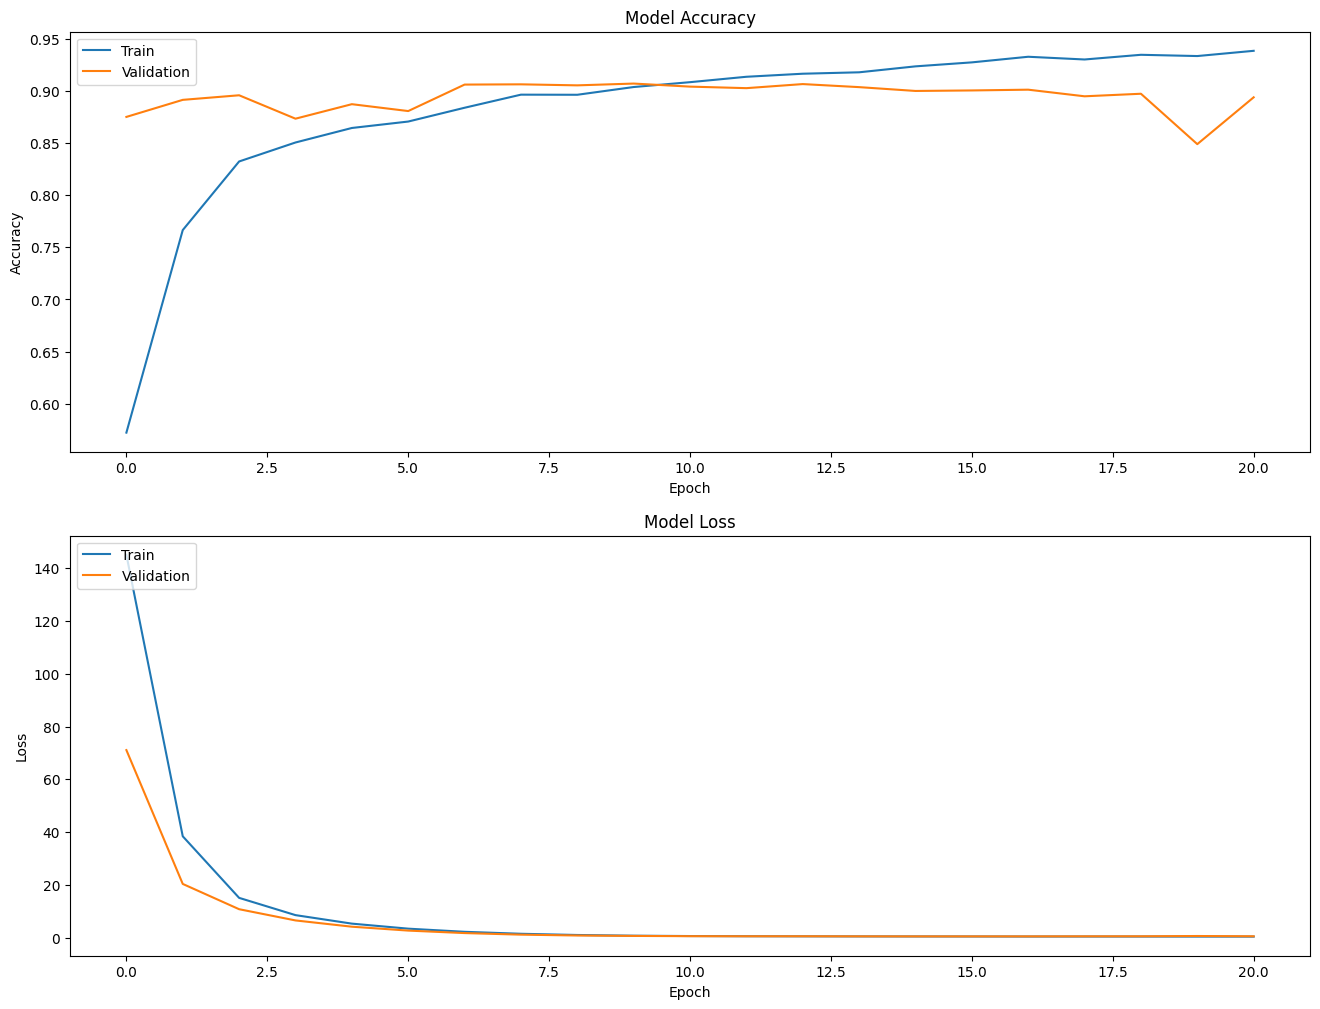

In [9]:
fig = plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

fig.savefig(save_folder + '/training.png')

In [10]:
# tokenize test data
tokens_test = tokenizer.batch_encode_plus(x_test, max_length=MAX_SEQUENCE_LENGTH, padding='max_length', truncation=True, return_tensors='tf')

input_ids_test = tokens_test['input_ids']
attention_mask_test = tokens_test['attention_mask']

texts_test = (input_ids_test, attention_mask_test)
labels_test = tf.constant(y_test)

In [11]:
# function to get accuracy of model predictions
def get_accuracy(pred, true):
    test_accuracy = accuracy_score(pred, true) * 100
    print('Accuracy: {:.2f}%'.format(test_accuracy))
    return test_accuracy

# retrieve model predictions on test data
y_pred = model.predict(texts_test)
y_pred = np.argmax(y_pred, axis=1)

# get accuracy of predictions
acc = get_accuracy(y_pred, y_test)

# save accuracy
with open(save_folder + "/accuracy_results.csv", "a") as f:
    writer = csv.writer(f)
    writer.writerow([acc])
    
acc

129/129 [==============================] - 22s 158ms/step
Accuracy: 88.91%


88.90514508656425

In [12]:
# create classification report
class_report = classification_report(y_pred, y_test, target_names=['CutFree', 'CutFreeRL'])

# save classification report
with open(save_folder + "/classification_report.csv", "a") as f:
    writer = csv.writer(f)
    writer.writerow([class_report])
    
print(class_report)

              precision    recall  f1-score   support

     CutFree       0.89      0.96      0.92      2864
   CutFreeRL       0.89      0.72      0.80      1237

    accuracy                           0.89      4101
   macro avg       0.89      0.84      0.86      4101
weighted avg       0.89      0.89      0.89      4101



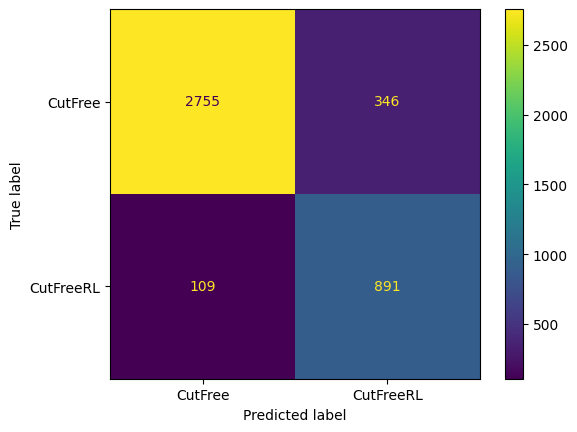

In [13]:
# create confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(cm, display_labels=['CutFree', 'CutFreeRL'])
fig.plot()

# save confusion matrix
plt.savefig(save_folder + '/confusion_matrix.png')

## Plot Correct Selection for CutFree and CutFreeRL

In [14]:
# set colors and font for plots
rgb = []
for _ in df[df['Algorithm'] == 0].index:
    c = [46/255, 108/255, 190/255]
    rgb.append(c)

rgb2 = []
for _ in df[df['Algorithm'] == 1].index:
    c = [220/255, 77/255, 58/255]
    rgb2.append(c)

gfont = {'fontname': 'Georgia'}
font = font_manager.FontProperties(family='Georgia', style='normal', size=32)

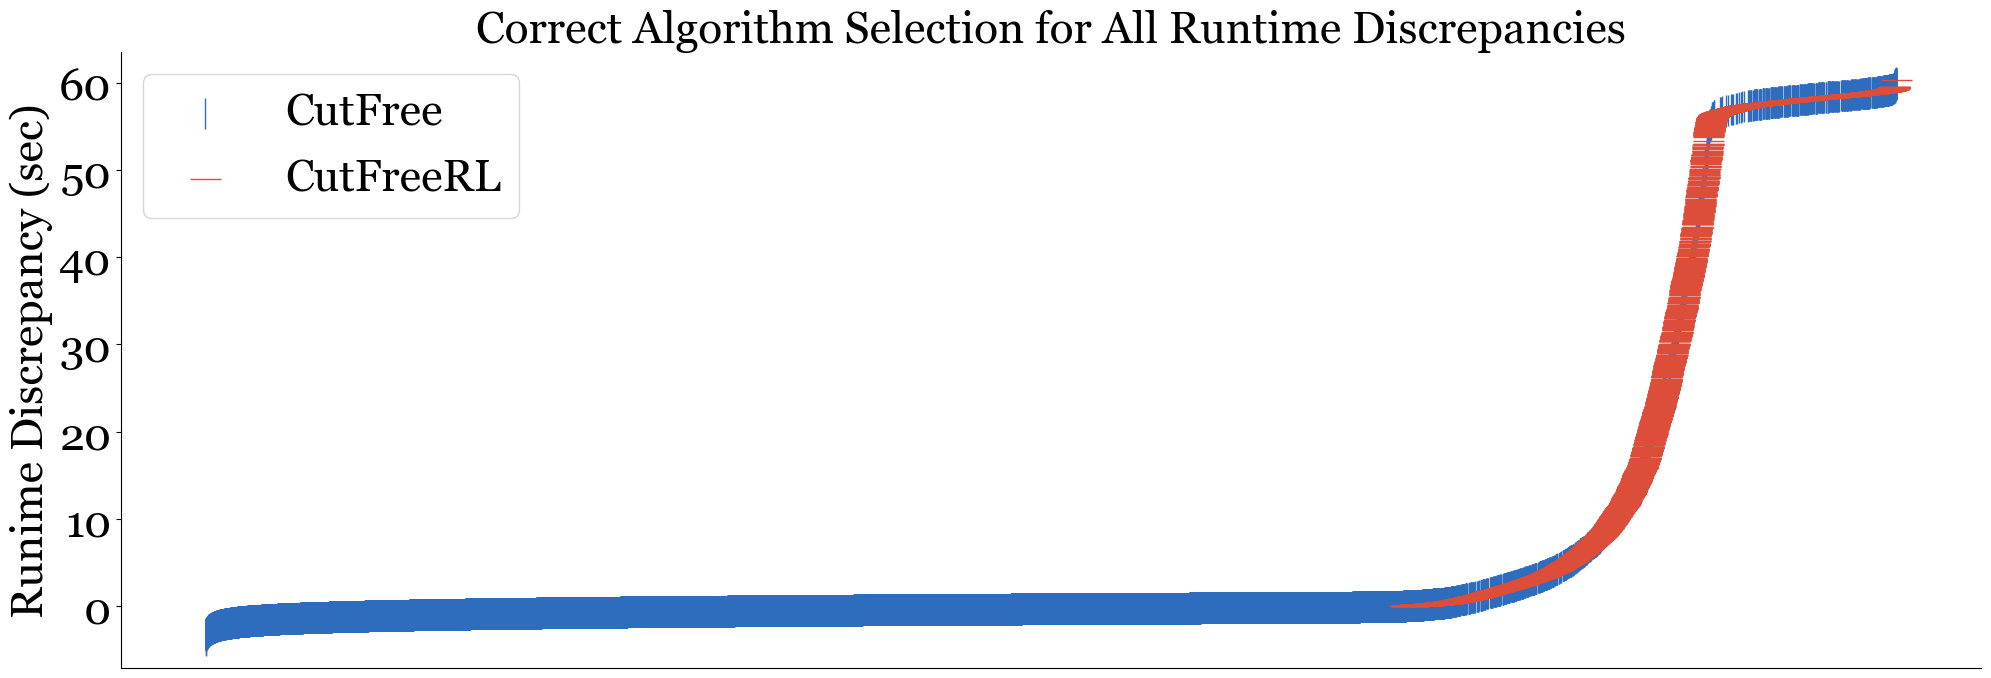

In [15]:
plt.figure(figsize=(24, 8))

# plot expected algorithm selection for all time discrepencies
plt.scatter(
    df[df['Algorithm'] == 0].index, df[df['Algorithm'] == 0]['Discrepancy'], 
    c=rgb,
    linewidths=1,
    marker='|',
    s=500)
plt.scatter(
    df[df['Algorithm'] == 1].index, df[df['Algorithm'] == 1]['Discrepancy'], 
    c=rgb2,
    linewidths=1,
    marker='_',
    s=500)
    
plt.title('Correct Algorithm Selection for All Runtime Discrepancies', fontsize=32, **gfont)
plt.ylabel('Runime Discrepancy (sec)', fontsize=32, **gfont)
plt.legend(['CutFree', 'CutFreeRL'], prop=font)
ax = plt.gca()
plt.xticks(fontsize=32, **gfont)
plt.yticks(fontsize=32, **gfont)
ax.get_xaxis().set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.savefig(save_folder + '/correct_algorithm_selection.png')

## Plot Predictions for Selection of CutFree and CutFreeRL

In [16]:
# organize test data for analysis
x_test = np.array(x_test)

# get oligos from test inputs
x_test_oligos = [i.split(';')[0] for i in x_test]

# get sites from test inputs
x_test_sites = [i.split(';')[1] for i in x_test]
x_test_sites = np.array(x_test_sites)
x_test_sites = [x_test_site.replace(' ', '') for x_test_site in x_test_sites]
x_test_sites = [x_test_site.split(',') for x_test_site in x_test_sites]

print(len(x_test_oligos), len(x_test_sites), len(y_test))

4101 4101 4101


In [17]:
# copy dataframe
df_test = df.copy()

# add prediction column using test data
for oligo, site, pred, test in zip(x_test_oligos, x_test_sites, y_pred, y_test):
    for index, (oligo_df, sites_df) in enumerate(zip(df_test['Oligo'].values, df_test['Sites'].values)):
        if (oligo == oligo_df) and (site == sites_df):
            df_test.loc[index, 'Prediction'] = pred == test

# drop unassigned rows
df_test = df_test.dropna(subset=['Prediction'])

# set prediction algorithm
cutfree_condition = ((df_test['Prediction'] == True) & (df_test['Algorithm'] == 0)) | ((df_test['Prediction'] == False) & (df_test['Algorithm'] == 1))
cutfreerl_condition = ((df_test['Prediction'] == True) & (df_test['Algorithm'] == 1)) | ((df_test['Prediction'] == False) & (df_test['Algorithm'] == 0))
df_test.loc[cutfree_condition, 'Prediction'] = 0
df_test.loc[cutfreerl_condition, 'Prediction'] = 1

# create correct/incorrect column
df_test['Correct'] = df_test['Algorithm'] == df_test['Prediction']

# sort dataframe by discrepency and reset index
df_test = df_test.sort_values(by=['Discrepancy'], ascending=True).reset_index(drop=True)

# check prediction column
df_test['Prediction'].value_counts() # 0 = CutFree, 1 = CutFreeRL

Prediction
0    2864
1    1237
Name: count, dtype: int64

C:\Users\wrick\AppData\Local\Temp\ipykernel_56196\1781095741.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


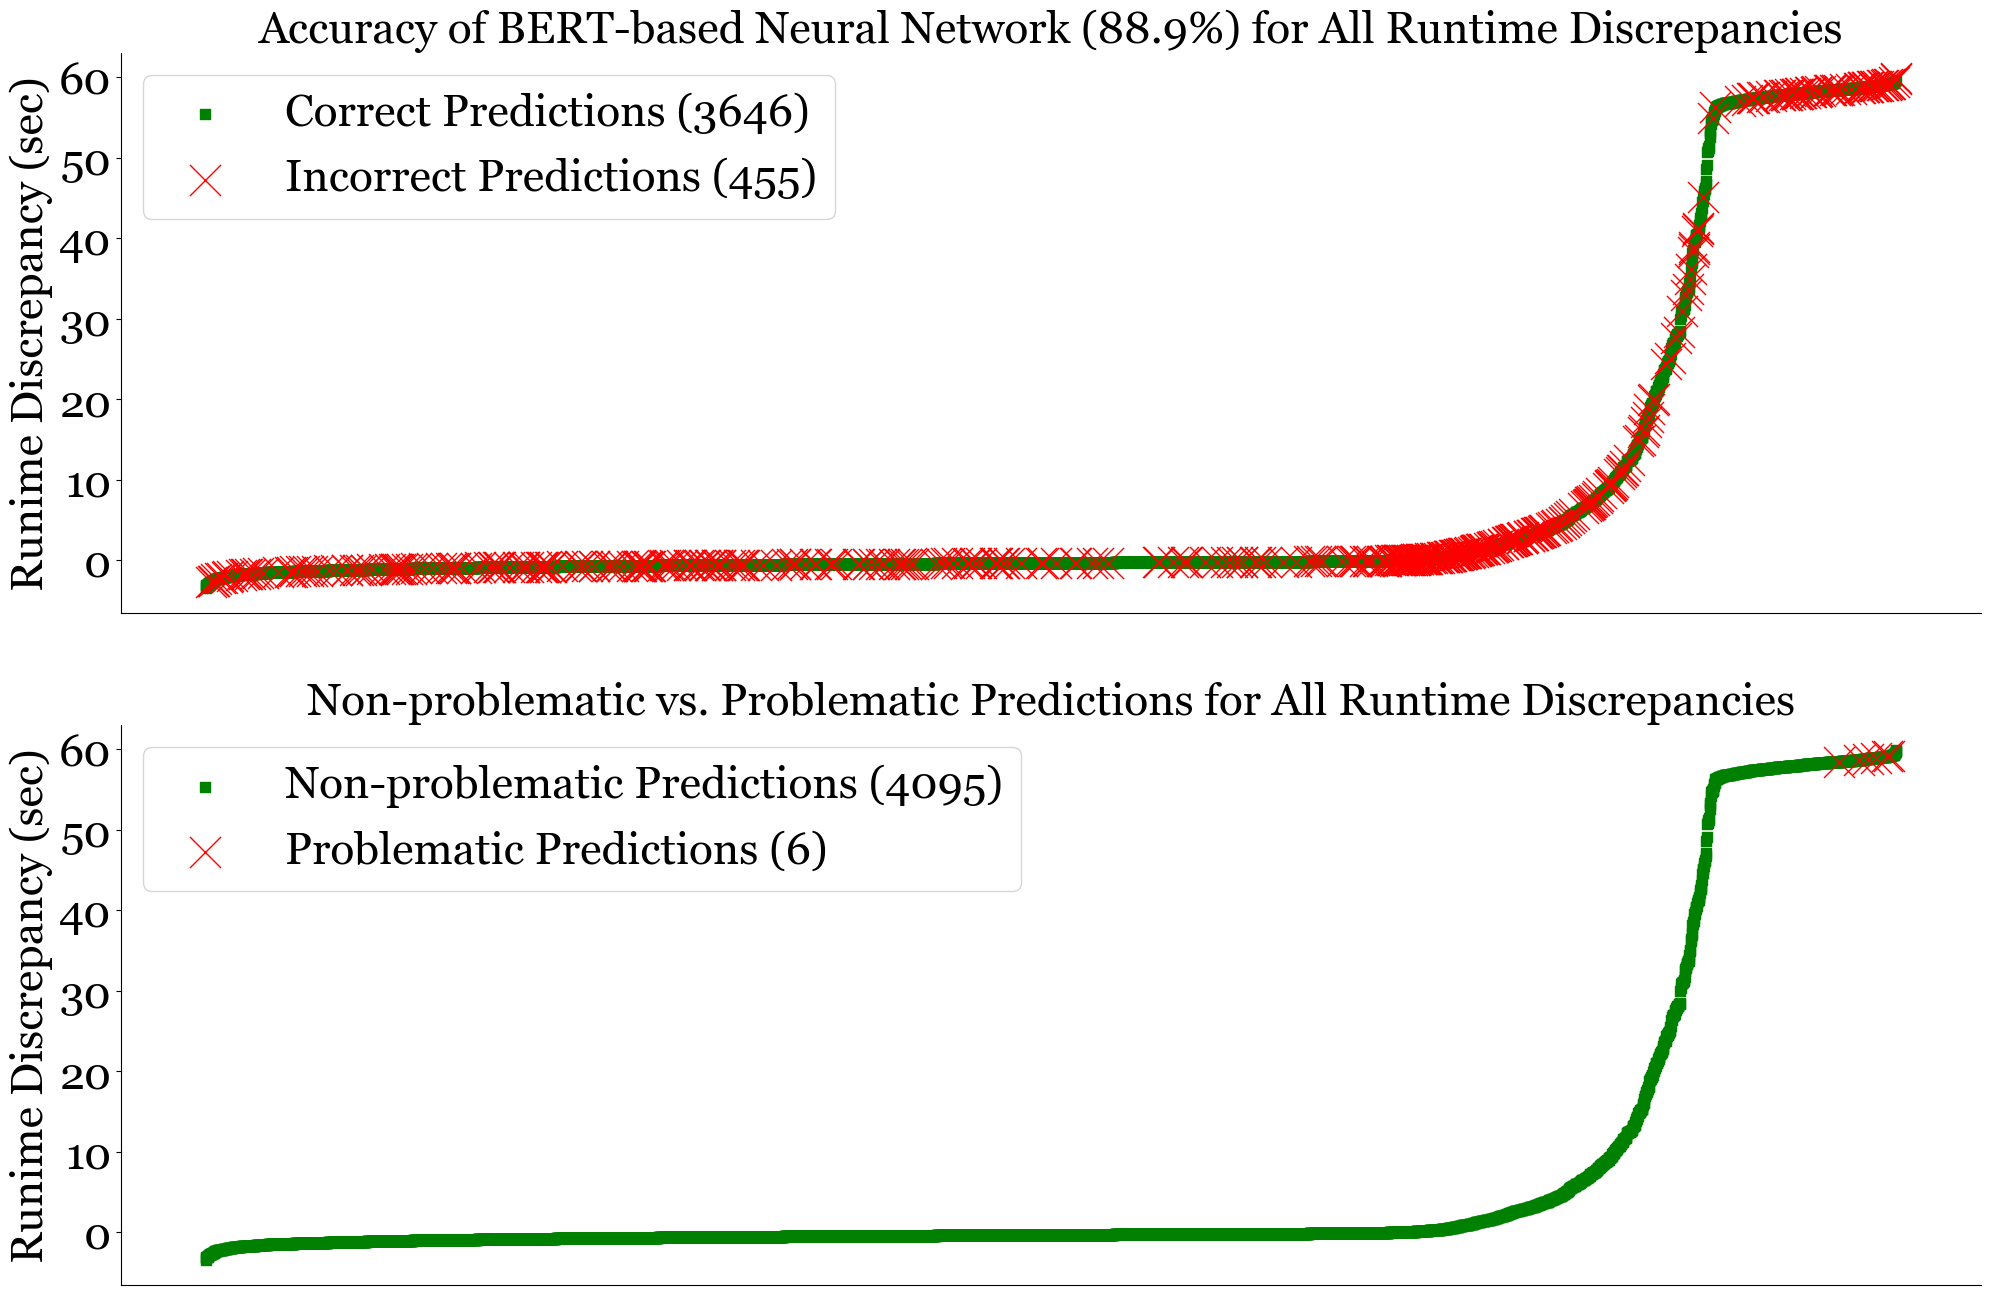

In [18]:
fig, ax = plt.subplots(figsize=(24, 16))

# plot correct and incorrect selections for all time discrepencies
plt.subplot(2, 1, 1)

correct_conditions = (df_test['Correct'] == True)
plt.scatter(
    df_test[correct_conditions].index,
    df_test.loc[correct_conditions, 'Discrepancy'], 
    c='g',
    linewidths=1,
    marker='s',
    s=50)

incorrect_conditions = (df_test['Correct'] == False)
plt.scatter(
    df_test[incorrect_conditions].index,
    df_test.loc[incorrect_conditions, 'Discrepancy'], 
    c='r',
    linewidths=1,
    marker='x',
    s=500)

plt.title(f'Accuracy of BERT-based Neural Network ({acc:.1f}%) for All Runtime Discrepancies', fontsize=32, **gfont)
plt.ylabel('Runime Discrepancy (sec)', fontsize=32, **gfont)
plt.legend([f'Correct Predictions ({len(df_test[correct_conditions])})', 
            f'Incorrect Predictions ({len(df_test[incorrect_conditions])})'], 
            prop=font)
ax = plt.gca()
plt.xticks(fontsize=32, **gfont)
plt.yticks(fontsize=32, **gfont)
ax.get_xaxis().set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# plot problematic selections for all time discrepencies
plt.subplot(2, 1, 2)

nonproblematic_conditions = (df_test['Correct'] == True) | ((df_test['Correct'] == False) & (df_test['Algorithm'] == 0)) | ((df_test['Correct'] == False) & (df_test['CutFree_Time'] <= 60))
plt.scatter(
    df_test[nonproblematic_conditions].index,
    df_test.loc[nonproblematic_conditions, 'Discrepancy'], 
    c='g',
    linewidths=1,
    marker='s',
    s=50)

# problematic conditions are defined as incorrect predictions that place the system at risk of runtime explosion
problematic_conditions = ((df_test['Correct'] == False) & (df_test['Algorithm'] == 1) & (df_test['CutFree_Time'] >= 60))
plt.scatter(
    df_test[problematic_conditions].index,
    df_test.loc[problematic_conditions, 'Discrepancy'], 
    c='r',
    linewidths=1,
    marker='x',
    s=500)

plt.title(f'Non-problematic vs. Problematic Predictions for All Runtime Discrepancies', fontsize=32, **gfont)
plt.ylabel('Runime Discrepancy (sec)', fontsize=32, **gfont)
plt.legend([f'Non-problematic Predictions ({len(df_test[nonproblematic_conditions])})', 
            f'Problematic Predictions ({len(df_test[problematic_conditions])})'], 
            prop=font)
ax = plt.gca()
plt.xticks(fontsize=32, **gfont)
plt.yticks(fontsize=32, **gfont)
ax.get_xaxis().set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.savefig(save_folder + '/runtime_discrepancies.png')

In [19]:
# get sensitivity for values above runtime limit
sensitivity = (len(df_test[nonproblematic_conditions])) / (len(df_test[nonproblematic_conditions]) + len(df_test[problematic_conditions])) * 100

# save sensitivity
with open(save_folder + "/sensitivity_results.csv", "a") as f:
    writer = csv.writer(f)
    writer.writerow([sensitivity])
    
sensitivity

99.85369422092172

## Get Average Model Statistics

In [21]:
# initialize values
average_sensitivity = np.array([])
average_acc = np.array([])

# retrieve all values from saved CSV files
for directory in os.listdir('models'):
    if directory.startswith('AlgorithmClassifier'):
        with open('models/' + directory + '/sensitivity_results.csv', 'r') as f:
            reader = csv.reader(f)
            for row in reader:
                if len(row) > 0:
                    average_sensitivity = np.append(average_sensitivity, float(row[0]))
        with open('models/' + directory + '/accuracy_results.csv', 'r') as f:
            reader = csv.reader(f)
            for row in reader:
                if len(row) > 0:
                    average_acc = np.append(average_acc, float(row[0]))
        n = len(average_sensitivity)

print(f"Average Sensitivity: {average_sensitivity.mean():.1f}% +/- {average_sensitivity.std():.5f}")
print(f"Average Accuracy: {average_acc.mean():.1f}% +/- {average_acc.std():.5f}")
print(f"Number of Trials: {n}")

Average Sensitivity: 99.6% +/- 0.47524
Average Accuracy: 88.8% +/- 2.10079
Number of Trials: 5


# Load Model and Make New Predictions

In [23]:
# import dependencies
import tensorflow as tf
import numpy as np
from transformers import DistilBertTokenizer, TFDistilBertModel, AdamWeightDecay

# load model
new_model = tf.keras.models.load_model(
    'models/AlgorithmClassifier-V0/checkpoints/model.24-0.889.h5',
    custom_objects={'TFDistilBertModel': TFDistilBertModel, 
                    'AdamWeightDecay': AdamWeightDecay})

# load tokenizer
new_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')        

In [24]:
# get input
text = 'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN; ACGWGN, TTTCGGCC, RTAGGCAY, CCTGCATAGG'
text_0 = 'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN; GCGGCCGC, GGCCGGCC, RTGCGCAY, CCTCGAGG'
text_1 = 'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN; CRCCGGYG, CCTCGAGG, GTTTAAAC, ATTTAAAT, CGCGCGCG, GGCGCGCC, RTGCGCAY, TTAATTAA, CGTCGACG, GCCCGGGC'

new_tokens_test = new_tokenizer.batch_encode_plus([text, text_0, text_1], max_length=256, padding='max_length', truncation=True, return_tensors='tf')

new_input_ids_test = new_tokens_test['input_ids']
new_attention_mask_test = new_tokens_test['attention_mask']

new_texts_test = (new_input_ids_test, new_attention_mask_test)

# predict
new_y_pred = np.argmax(new_model.predict(new_texts_test), axis=1)

print('Reconstructed Model Prediction (0 = CutFree, 1 = CutFreeRL): ', new_y_pred)

1/1 [==============================] - 2s 2s/step
Reconstructed Model Prediction (0 = CutFree, 1 = CutFreeRL):  [1 0 1]
